In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.style.use('seaborn')

This notebook will process Albin's continuous stake data for plotting against EB output results.

In [26]:
site = 'AB'
yr = '23'
base_fp = '~/research/MB_data/Gulkana/field_data/'
density_fn = 'Syr_snowsampling.xlsx'.replace('yr',yr)
stake_fn = 'BandedStake_MB.xlsx'
export_fn = '~/research/MB_data/Stakes/gulkanasiteyr.csv'.replace('site',site).replace('yr',yr)

## 1. Load Density Profile
Density profile comes from snowpit measurements and will be interpolated. 

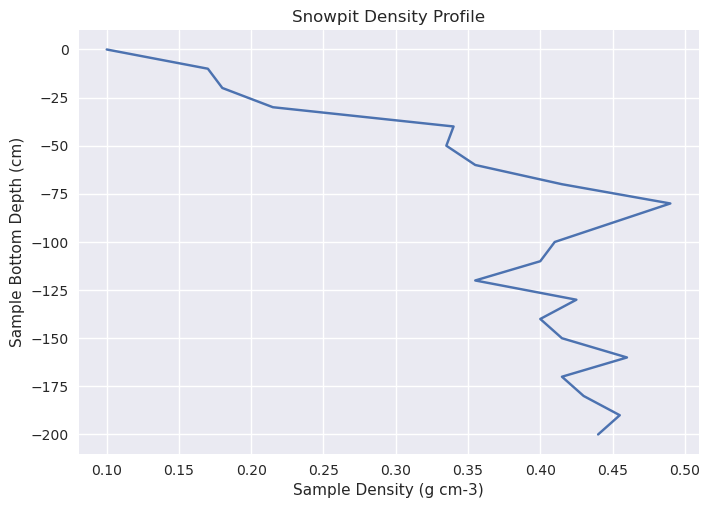

In [27]:
# read in density data
density_df = pd.read_excel(base_fp+density_fn,skiprows=2,sheet_name=site)

# convert data to numpy arrays
sbd = density_df['Sample Bottom Depth'][1:].to_numpy()
density = density_df['Density'][1:].to_numpy()

# add data points at bottom depth of 0 since the data will be interpolated
# (must be continuous from 0 --> bottom depth of ice)
sbd = np.append(np.array([0]),sbd).astype(float)
density = np.append(np.array([0.1]),density).astype(float)

# plot data to visualize density profile
plt.plot(density,-sbd)
plt.ylabel('Sample Bottom Depth (cm)')
plt.xlabel('Sample Density (g cm-3)')
plt.title('Snowpit Density Profile')
plt.show()

## 2. Calculate density of imaginary layers melted
The input data has the height of the surface at each time step. Thus the 'sample bottom depth' of the snow that was just melted is equal to the difference of the original snow height and the height of the snow at that time step. In this way the density of the snow melted each timestep can be interpolated from the data (assuming the density profile is time-invariant) and used to transform surface height to mass balance in m w.e.

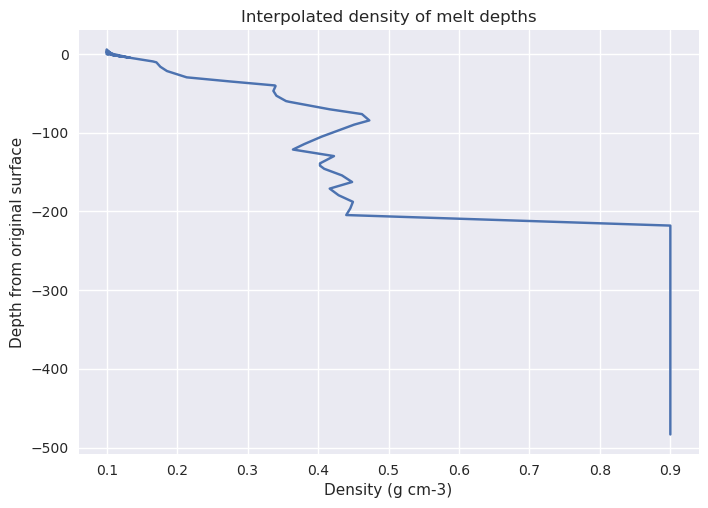

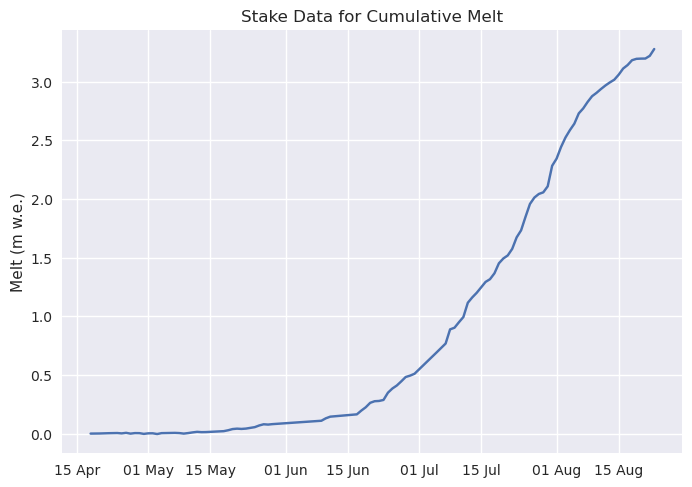

In [28]:
# read in stake data
stake_df = pd.read_excel(base_fp+stake_fn,sheet_name=yr+site+'-Banded',skiprows=1)

# select columns to interpolate and rename to clean names
df = stake_df[['Daily dhdt','Date','Sfc type','Height']][1:129]
df = df.rename(columns={'Daily dhdt':'dhdtAB','Sfc type':'surftype'})
df = df.set_index(pd.to_datetime(df['Date']))

# interpolate height to fill in blanks
df['Height'] = df['Height'].interpolate('linear')

# "sample bottom depth" is calculated for the heights of snow melted each day
depth_melted = df['Height'].to_numpy()[0] - df['Height'].to_numpy()

# interpolate density using "sample bottom depths" (depth_melted)
# density needed to get mass balance in m w.e.
df['density'] = np.interp(depth_melted.astype(float),sbd,density)
df['density'] = df['density'].mask(df['surftype']=='Ice',0.9)
df['melt'] = -df['dhdtAB']*df['density']/100 # g/cm2 --> m w.e.

# plot density to visually inspect
plt.plot(df['density'],-depth_melted)
plt.ylabel('Depth from original surface')
plt.xlabel('Density (g cm-3)')
plt.title('Interpolated density of melt depths')
plt.show()

# plot melt to visually inspect
fig,ax = plt.subplots()
ax.plot(df.index,np.cumsum(df['melt'].to_numpy()))
ax.set_title('Stake Data for Cumulative Melt')
ax.set_ylabel('Melt (m w.e.)')
date_form = mpl.dates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(date_form)
plt.show()

## 3. Calculate snow depth

For direct comparison to model output snow depth.

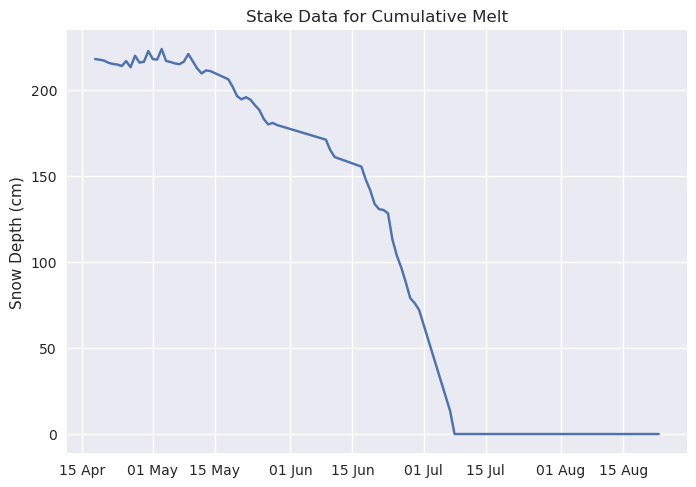

In [29]:
# get height of the ice compared to original surface
ice_height = df['Height'].iloc[np.where(df['surftype']=='Ice')[0][0]]
df['snow_depth'] = df['Height'] - ice_height
df['snow_depth'] = df['snow_depth'].mask(df['snow_depth']<0,0)

# plot snow depth to visually inspect
fig,ax = plt.subplots()
ax.plot(df.index,df['snow_depth'])
ax.set_title('Stake Data for Cumulative Melt')
ax.set_ylabel('Snow Depth (cm)')
date_form = mpl.dates.DateFormatter('%d %b')
ax.xaxis.set_major_formatter(date_form)
plt.show()

In [30]:
print(df)
df.to_csv(export_fn)

            dhdtAB       Date surftype  Height  density      melt  snow_depth
Date                                                                         
2023-04-18   -1.02 2023-04-18     Snow  817.60  0.10000  0.001020      217.98
2023-04-19   -0.35 2023-04-19     Snow  817.25  0.10245  0.000359      217.63
2023-04-20   -0.52 2023-04-20     Snow  816.73  0.10609  0.000552      217.11
2023-04-21   -1.29 2023-04-21     Snow  815.44  0.11512  0.001485      215.82
2023-04-22   -0.71 2023-04-22     Snow  814.73  0.12009  0.000853      215.11
...            ...        ...      ...     ...      ...       ...         ...
2023-08-19   -1.32 2023-08-19      Ice  343.45  0.90000  0.011880        0.00
2023-08-20   -0.20 2023-08-20      Ice  343.25  0.90000  0.001800        0.00
2023-08-21   -0.07 2023-08-21      Ice  343.18  0.90000  0.000630        0.00
2023-08-22   -2.56 2023-08-22      Ice  340.62  0.90000  0.023040        0.00
2023-08-23   -6.45 2023-08-23      Ice  334.17  0.90000  0.05805